In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from matplotlib import cm
from scipy import ndimage
from skimage.morphology import watershed
import pickle

In [142]:
MIN = 0
MAX = 2 ** 16 - 1

# import all images per sequence, return images
def import_sequences():
    PATH = '../sequences/0'
    imgs = []
    for i in range(1, 5):
        imgs_path = []
        for image in glob(f'{PATH}{i}/*.tif'):
            img = cv2.imread(image, -1)
            imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
        imgs.append(imgs_path)
    return imgs

NROWS = 700
NCOLS = 1100
NUM_IMAGES = 92

def segment(img):
    # CLAHE preprocess: segment from background
    clahe = cv2.createCLAHE(clipLimit=80.0, tileGridSize=(25,25))
    cl1 = clahe.apply(img)

    hist = cv2.calcHist([cl1],[0],None,[257],[0,MAX])
    from_max = hist[np.argmax(hist):]
    for intensity, _ in enumerate(from_max[:-1]):
        if from_max[intensity+1] >= from_max[intensity]:
            for i in range(30):
                if intensity + i >= len(from_max):
                    break
                if from_max[intensity + i] < intensity - 250:
                    break
            else:
                break

    final = (intensity + np.argmax(hist)) * 255
    seg = np.zeros_like(cl1)
    cv2.threshold(cl1, dst=seg, thresh=final, maxval=MAX, type=cv2.THRESH_BINARY)
    opens = np.zeros_like(seg)
    elem = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5,5))
    cv2.morphologyEx(seg, dst=opens, op=cv2.MORPH_OPEN, kernel=elem)

    # watershed: segment cells from each other
    distance = ndimage.distance_transform_edt(opens)
    coords = peak_local_max(distance, footprint=np.ones((5,5)), min_distance = 20, labels = opens)
    mask = np.zeros(distance.shape, dtype = bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    ws_labels = watershed(-distance, markers, mask = opens)
    ws_pts = {}
    for i in range(opens.shape[0]):
        for j in range(opens.shape[1]):
            if ws_labels[i,j] == 0:
                continue
            ws_pts[(i,j)] = ws_labels[i,j]-1

    labels = get_labels(ws_pts)
    new_pts = {}
    for label, cell_pts in labels.items():
        dilated = cell_pts.copy()
        for _ in range(3):
            dilated = dilate(dilated)

        eroded = dilated.copy()
        for _ in range(3):
            eroded = erode(eroded)

        for pt, label in eroded.items():
            new_pts[pt] = label

    # mix local labels
    all_pts = new_pts.copy()
    cents = centroids(new_pts)
    len(cents)
    shuffled = np.arange(0, len(cents))
    np.random.shuffle(shuffled)
    swap_labels = {}
    for i, label in enumerate(cents.values()):
        swap_labels[label] = shuffled[i]
    pts = {}
    for pt, label in all_pts.items():
        pts[pt] = swap_labels[label]
    
    # delete small cells
    labels = get_labels(pts)
    temp_pts = pts.copy()
    del_labels = []
    for label,pts1 in labels.items():
        if len(pts1) < 50:
            del_labels.append(label)
    for pt, label in pts.items():
        if label in del_labels: 
            del temp_pts[pt]

    return temp_pts

# show an image inline
def show(img, s=True):
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

# get white points of an image, return dict of coord tuples
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

# flush all cells that touch the border of the image
def flush_border_cells(pts, img):
    to_check = []
    border_pts = {}
    border_img = np.zeros((NROWS, NCOLS))
    for pt in pts:
        if pt[0] == 0 or pt[1] == 0 or pt[0] == NROWS-1 or pt[1] == NCOLS-1:
            to_check.append(pt)
            border_pts[pt] = None
            border_img[pt[0], pt[1]] = MAX
    while len(to_check) > 0:
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
    new = img - border_img
    return points(new), new.astype('uint16')

# create an image from points
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new.astype('uint16')

# binary erosion of points with 3x3 filter
def erode(pts):
    eroded1_pts = {}
    for (x,y) in pts:
        if (x,y-1) in pts and (x, y+1) in pts:
            eroded1_pts[(x,y)] = pts[(x,y)]
    eroded2_pts = {}
    for (x,y) in eroded1_pts:
        if (x-1,y) in eroded1_pts and (x+1, y) in eroded1_pts:
            eroded2_pts[(x,y)] = eroded1_pts[(x,y)]
    return eroded2_pts

# check coords within image bounds
def check_coords(pt):
    if pt[0] < 0 or pt[0] > NROWS-1 or pt[1] < 0 or pt[1] > NCOLS-1:
        return False
    return True

# binary dialtion of points with 3x3 filter
def dilate(pts):
    dilated1_pts = pts.copy()
    for (x,y) in pts:
        if (x,y-1) not in pts and check_coords((x,y-1)):
            dilated1_pts[(x, y-1)] = pts[(x,y)]
        if (x, y+1) not in pts and check_coords((x,y+1)):
            dilated1_pts[(x, y+1)] = pts[(x,y)]
    dilated2_pts = dilated1_pts.copy()
    for (x,y) in dilated1_pts:
        if (x-1,y) not in dilated1_pts and check_coords((x-1,y)):
            dilated2_pts[(x-1, y)] = dilated1_pts[(x,y)]
        if (x+1, y) not in dilated1_pts and check_coords((x+1,y)):  
            dilated2_pts[(x+1, y)] = dilated1_pts[(x,y)]
    return dilated2_pts

# from points and labels create a coloured image
def colour_label_image(pts_labels, show_img=True, max=None):
    cmap = cm.get_cmap('hsv').copy()
    new_img = np.zeros((NROWS, NCOLS))
    cmap.set_bad(color='black')
    for (pt, label) in pts_labels.items():
        new_img[pt[0],pt[1]] = label
    if max == None:
        norm_new = plt.Normalize(new_img.min(), new_img.max())
    else:
        norm_new = plt.Normalize(new_img.min(), max)
    for i in range(NROWS):
        for j in range(NCOLS):
            if (i,j) not in pts_labels:
                new_img[i,j] = np.nan
    rgba_img = cmap(norm_new(new_img))
    if show_img:
        show(rgba_img)
    return rgba_img

# plot scatter of centroids over the colour labelled image
def plt_rgb_img_scatter(centroids, pts_labels, change=None, max=None):
    rgb_img = colour_label_image(pts_labels, False, max)
    plt.figure(figsize=(15,15))
    plt.imshow(rgb_img)
    for (x, y) in centroids.keys():
        plt.scatter(y, x, c='white', marker='.')
    if change != None:
        for i,j  in change.values():
            plt.plot(j,i, c='white')
    plt.show()

# get cell contours (outlines) from points
def contours(pts):
    dilated2_pts = dilate(pts)
    sub = {}
    for pt, label in dilated2_pts.items():
        if pt not in pts:
            sub[pt] = label
    return sub

# find average size of cells in the image
def avg_cell_size(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(pts) / len(labels)

# count the number of cells in the image
def cell_count(pts):
    labels = {}
    for label in pts.values():
        labels[label] = None
    return len(labels)

# use watershed after Chan-Vese to get best results
def watershed_seg(img, min_dist=20):
    distance = ndimage.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((5,5)), min_distance = min_dist, labels = img)
    mask = np.zeros(distance.shape, dtype = bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    ws_labels = watershed(-distance, markers, mask = img)
    ws_pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if ws_labels[i,j] == 0:
                continue
            ws_pts[(i,j)] = ws_labels[i,j]-1
    return ws_pts

# get centroids from points
def centroids(pts):
    labels = {}
    for (x,y), label in pts.items():
        if label not in labels:
            labels[label] = {'x': [x], 'y': [y]}
            continue
        labels[label]['x'].append(x)
        labels[label]['y'].append(y)
    centres = {}
    for label, data in labels.items():
        centres[int(sum(data['x'])/len(data['x'])), 
                int(sum(data['y'])/len(data['y']))] = label
    return centres

def mix_labels(pts):
    all_pts = pts.copy()
    cents = centroids(pts)
    len(cents)
    shuffled = np.arange(0, len(cents))
    np.random.shuffle(shuffled)
    swap_labels = {}
    for i, label in enumerate(cents.values()):
        swap_labels[label] = shuffled[i]
    pts = {}
    for pt, label in all_pts.items():
        pts[pt] = swap_labels[label]
    return pts

def segment_CLAHE(img, show_img=False):
    clahe = cv2.createCLAHE(clipLimit=80.0, tileGridSize=(25,25))
    cl1 = clahe.apply(img)

    hist = cv2.calcHist([cl1],[0],None,[257],[0,MAX])
    from_max = hist[np.argmax(hist):]
    for intensity, num in enumerate(from_max[:-1]):
        if from_max[intensity+1] >= from_max[intensity]:
            for i in range(30):
                if intensity + i >= len(from_max):
                    break
                if from_max[intensity + i] < intensity - 250:
                    break
            else:
                break

    final = (intensity + np.argmax(hist)) * 255
    seg = np.zeros_like(cl1)
    cv2.threshold(cl1, dst=seg, thresh=final, maxval=MAX, type=cv2.THRESH_BINARY)
    opens = np.zeros_like(seg)
    elem = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5,5))
    cv2.morphologyEx(seg, dst=opens, op=cv2.MORPH_OPEN, kernel=elem)
    if show_img:
        show(img)
        show(opens)
        plt.figure(figsize=(15,15))
        plt.hist(cl1.ravel(),255)
        plt.axvline(x=final, color='r')
        plt.show()
    return opens

def delete_small(pts, area=10000):
    labels = get_labels(pts)
    temp_pts = pts.copy()
    del_labels = []
    for label,pts in labels.items():
        if len(pts) < area:
            del_labels.append(label)
    for pt, label in pts.items():
        if label in del_labels: 
            del temp_pts[pt]
    return temp_pts

def segment_img(img):
    thresh = segment_CLAHE(img)
    ws_pts = watershed_seg(thresh, min_dist=17)
    new_pts = seperate_open(ws_pts)
    mixed_pts = mix_labels(new_pts)
    big_pts = delete_small(mixed_pts)
    return big_pts

def get_labels(pts):
    label = {}
    for pt, lbl in pts.items():
        if lbl not in label:
            label[lbl] = {pt: lbl}
        else:
            label[lbl][pt] = lbl
    return label

# close cells in individual vector space so cells are not joined by closing op
def seperate_open(pts, sweeps=3):
    labels = get_labels(pts)
    new_pts = {}
    for label, cell_pts in labels.items():
        dilated = cell_pts.copy()
        for _ in range(sweeps):
            dilated = dilate(dilated)

        eroded = dilated.copy()
        for _ in range(sweeps):
            eroded = erode(eroded)

        for pt, label in eroded.items():
            new_pts[pt] = label
    return new_pts

def dump_obj(obj, filepath):
    with open(filepath, 'wb') as outfile:
        pickle.dump(obj, outfile)

def load_obj(filepath):
    with open(filepath, 'rb') as infile:
        return pickle.load(infile)

def centroid_four(pts):
    pt1 = list(pts.keys())[0]
    extrema = {}
    for pt, label in pts.items():
        if label not in extrema:
            extrema[label] = {'i1': pt[0], 'i2':pt[0], 'j1':pt[1], 'j2':pt[1]}
        else:
            if pt[0] < extrema[label]['i1']:
                extrema[label]['i1'] = pt[0]
            elif pt[0] > extrema[label]['i2']:
                extrema[label]['i2'] = pt[0]
            
            if pt[1] < extrema[label]['j1']:
                extrema[label]['j1'] = pt[1]
            elif pt[1] > extrema[label]['j2']:
                extrema[label]['j2'] = pt[1]
    cents = {}
    for label,vals in extrema.items():
        cents[(vals['i1']+vals['i2'])/2,(vals['j1']+vals['j2'])/2] = label
    return cents

In [68]:
imgs = import_sequences()

In [ ]:
seq = {}
for i,sequence in enumerate(imgs):
    seq[i] = {}
    for j,img in enumerate(sequence):
        seq[i][j] = segment(img)

In [4]:
def distance_matrix(cent1, cent2):
    dist_mat = np.zeros((len(cent1), len(cent2)))
    rows, cols = {}, {}
    for i, pt1 in enumerate(cent1.keys()):
        rows[i] = pt1
        for j, pt2 in enumerate(cent2.keys()):
            dist_mat[i,j] = np.sqrt(np.square(pt1[0]-pt2[0]) + np.square(pt1[1]-pt2[1]))
    for j, pt2 in enumerate(cent2.keys()):
        cols[j] = pt2
    return dist_mat, rows, cols

In [5]:
seq = load_obj('sequence_1.p')

In [45]:
cent0, cent1 = centroids(seq[0]), centroids(seq[1])
dist_mat, rows, cols = distance_matrix(cent0, cent1)

In [46]:
sequence_labels = {0: cent0.copy(), -1: len(cent0)}

In [120]:
centroid_paths = {}
for pt, label in sequence_labels[0].items():
    centroid_paths[label] = {}
    centroid_paths[label][0] = pt

In [51]:
global_labels = {0: seq[0].copy()}

In [62]:
displacement = {0: {}}
for label in sequence_labels[0].values():
    displacement[0][label] = 0

In [64]:
sequence_labels[1] = {}
displacement[1] = {}
new_cells = cent1.copy()
for i, row in enumerate(dist_mat):
    if np.amin(row) > 50:
        continue
    sequence_labels[1][cols[np.argmin(row)]] = sequence_labels[0][rows[i]]
    displacement[1][sequence_labels[0][rows[i]]] = np.amin(row)
    if cols[np.argmin(row)] in new_cells:
        del new_cells[cols[np.argmin(row)]]
for new in new_cells.keys():
    sequence_labels[1][new] = sequence_labels[-1]
    sequence_labels[-1] += 1

In [123]:
for pt, label in sequence_labels[1].items():
    if label not in centroid_paths:
        centroid_paths[label] = {}
    centroid_paths[label][1] = pt

In [53]:
global_labels[1] = {}
for pt, local in seq[1].items():
    for cent, global_label in sequence_labels[1].items():
        if seq[1][cent] == local:
            global_labels[1][pt] = global_label
            continue   

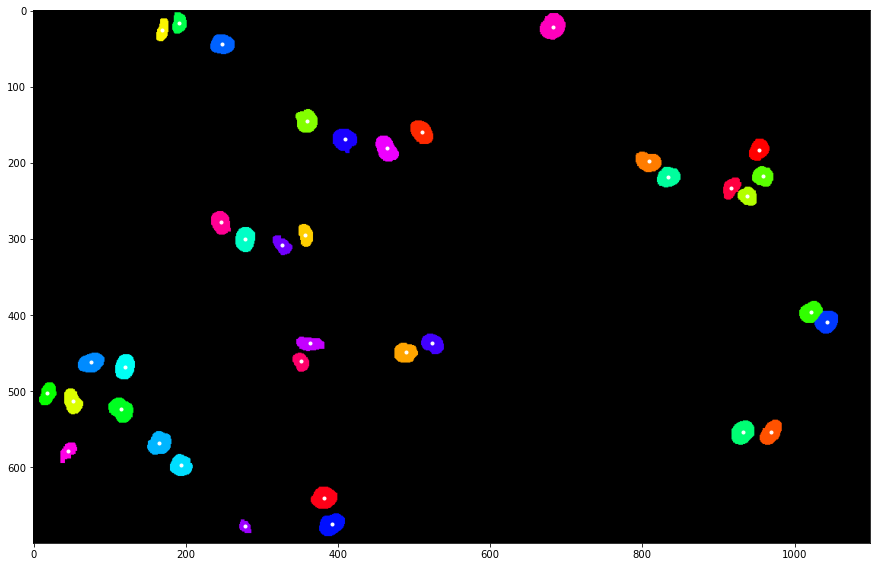

In [56]:
plt_rgb_img_scatter(cent0, global_labels[0])

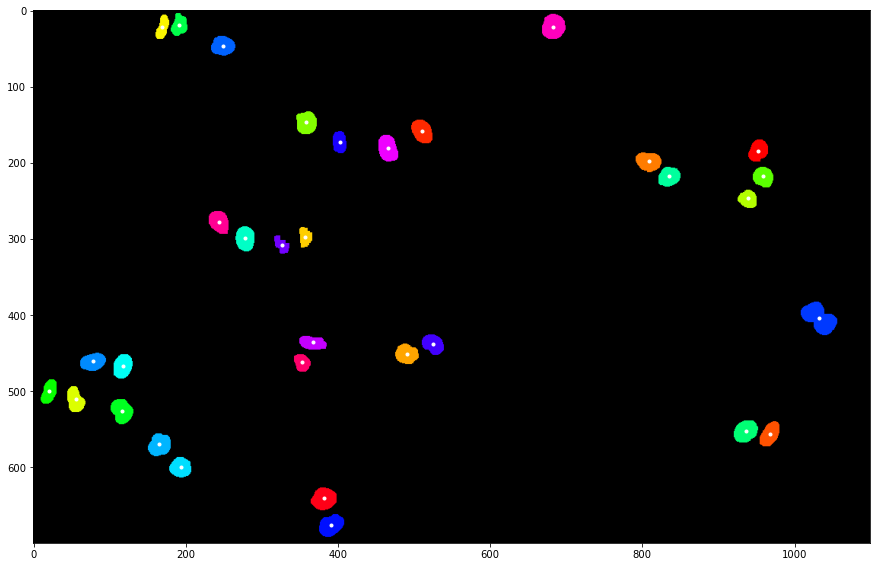

In [57]:
plt_rgb_img_scatter(cent1, global_labels[1])

In [124]:
change = {}
for label, paths in centroid_paths.items():
    if 0 in paths and 1 in paths:
        change[label] = ([paths[0][0], paths[1][0]],[paths[0][1], paths[1][1]])

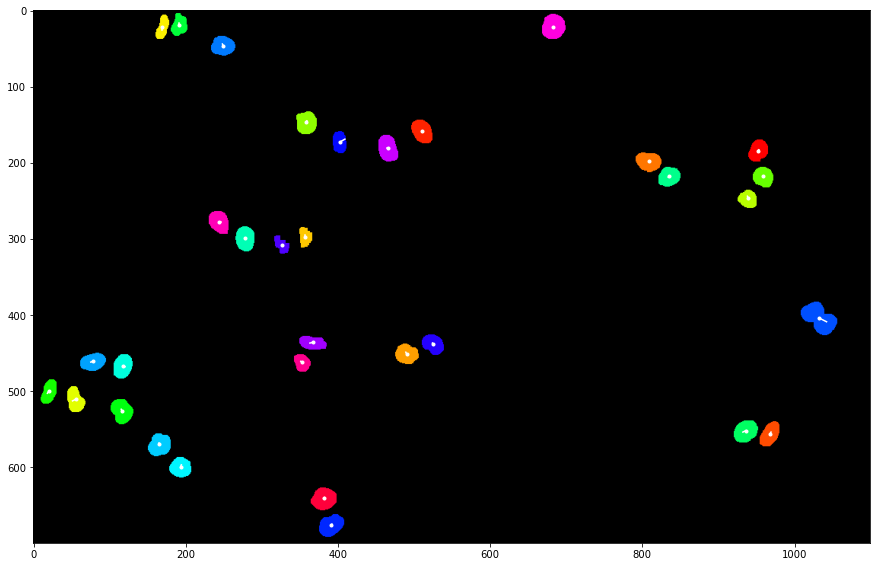

In [125]:
#plt_rgb_img_scatter(cent1, global_labels[1], change, sequence_labels[-1])
plt_rgb_img_scatter(cent1, global_labels[1], change, sequence_labels[-1])

In [147]:
def nearest_neighbour(seq, show_img=True):
    # intialise values and tracking data
    init_centroid = centroids(seq[0])
    cent_global_labels = {0: init_centroid.copy(), -1: len(init_centroid)}
    
    centroid_paths = {}
    for pt, label in cent_global_labels[0].items():
        centroid_paths[label] = {}
        centroid_paths[label][0] = pt
    
    global_labels = {0: seq[0].copy()}
    plt_rgb_img_scatter(init_centroid, global_labels[0], change=None, max=sequence_labels[-1])

    displacement = {0: {}}
    for label in cent_global_labels[0].values():
            displacement[0][label] = 0

    for t in range(len(seq)-1):
        cent0, cent1 = centroids(seq[t]), centroids(seq[t+1])
        dist_mat, rows, cols = distance_matrix(cent0, cent1)
  
        
        cent_global_labels[t+1] = {}
        displacement[t+1] = {}
        new_cells = cent1.copy()
        for i, row in enumerate(dist_mat):
            if np.amin(row) > 50:
                continue
            cent_global_labels[t+1][cols[np.argmin(row)]] = cent_global_labels[t][rows[i]]
            displacement[t+1][cent_global_labels[t][rows[i]]] = np.amin(row)
            if cols[np.argmin(row)] in new_cells:
                del new_cells[cols[np.argmin(row)]]
        for new in new_cells.keys():
            cent_global_labels[t+1][new] = cent_global_labels[-1]
            cent_global_labels[-1] += 1
        
        for pt, label in cent_global_labels[1].items():
            if label not in centroid_paths:
                centroid_paths[label] = {}
            centroid_paths[label][t] = pt
        
        global_labels[t+1] = {}
        for pt, local in seq[t+1].items():
            for cent, global_label in cent_global_labels[t+1].items():
                if seq[t+1][cent] == local:
                    global_labels[t+1][pt] = global_label
                    continue
        
        change = {}
        for label, paths in centroid_paths.items():
            if t in paths and t+1 in paths:
                change[label] = ([paths[t][0], paths[t+1][0]],[paths[t][1], paths[t+1][1]])

        if show_img:
            plt_rgb_img_scatter(cent1, global_labels[t+1], change, sequence_labels[-1])

In [139]:
subset = {}
for i, (time, data) in enumerate(seq.items()):
    if i > 5:
        break
    subset[time] = {}
    subset[time] = data

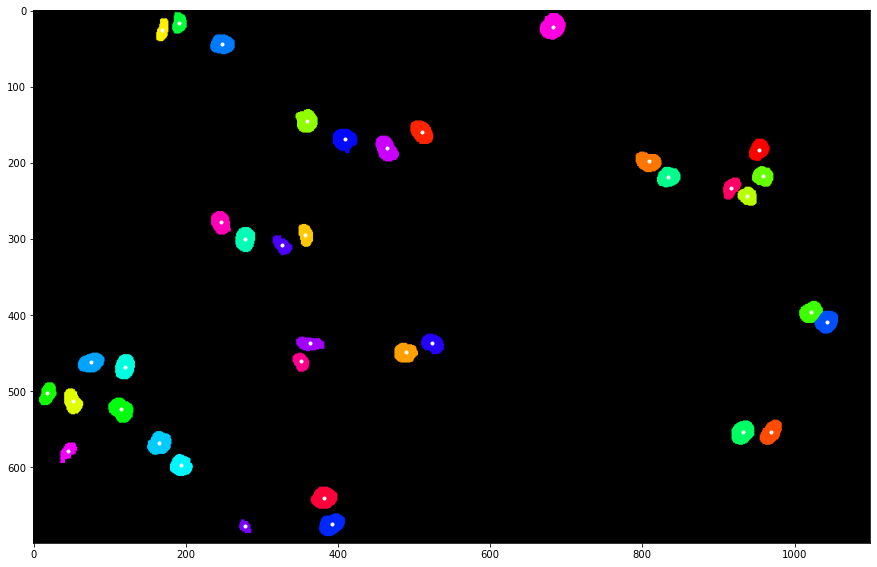

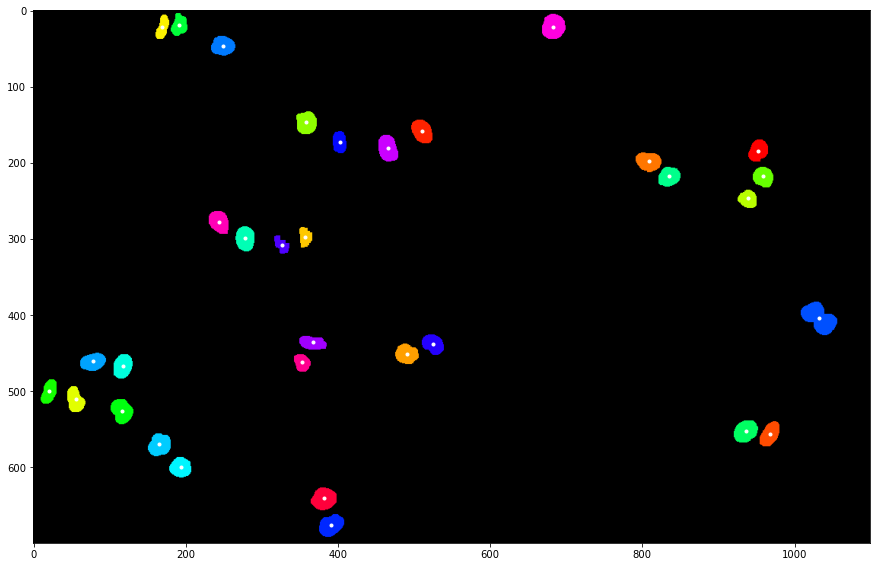

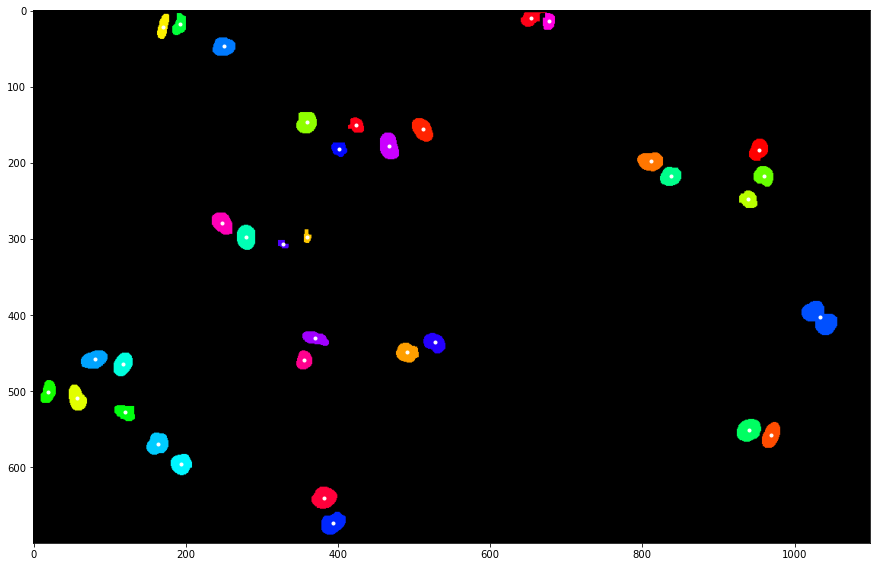

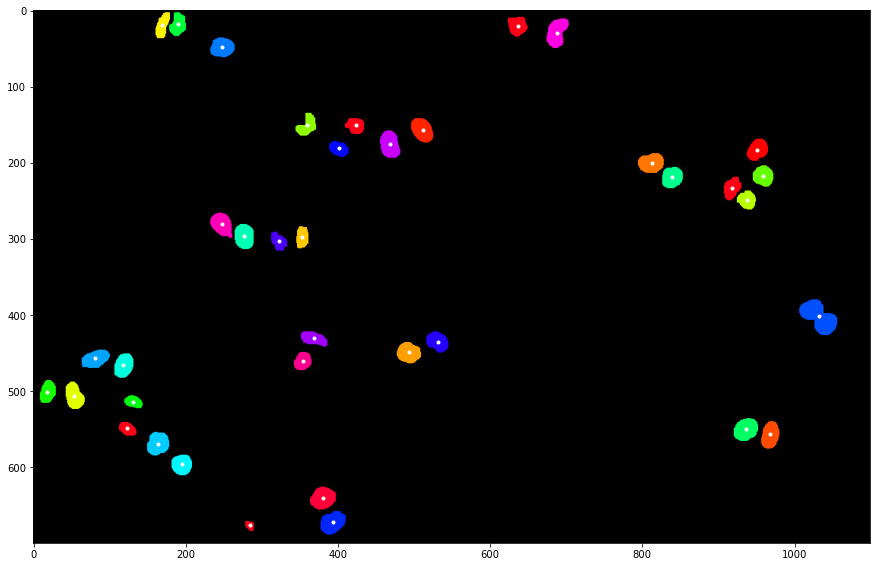

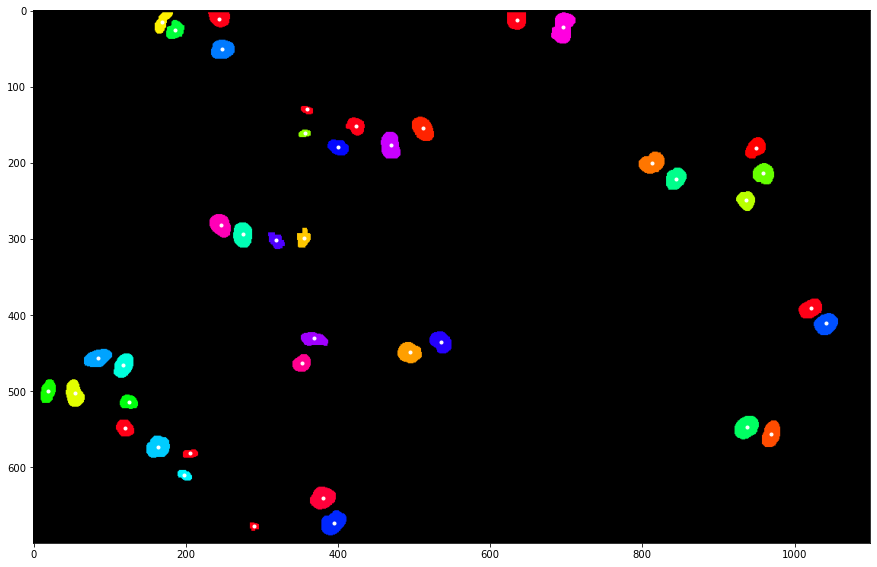

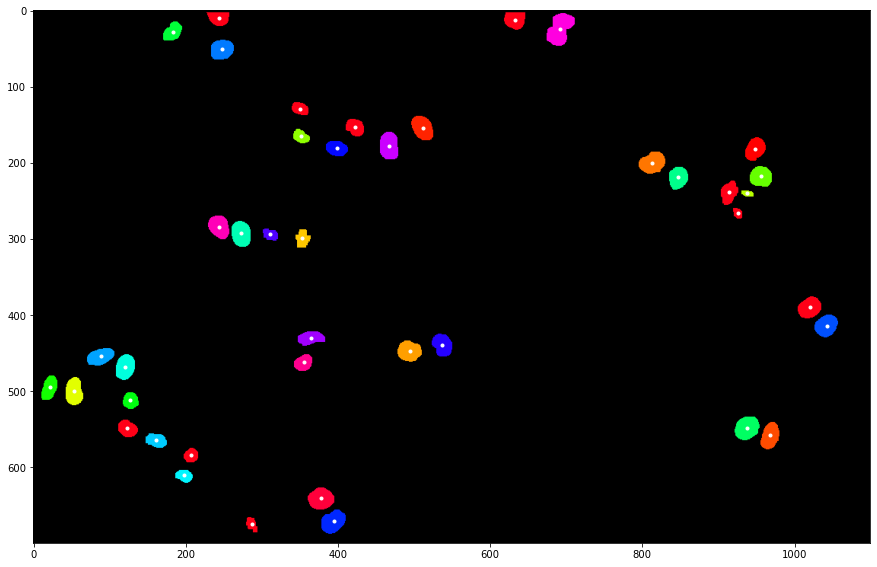

In [148]:
nearest_neighbour(subset)